# Training Variational Quantum Models with Barren Plateaus Mitigation Strategies
*Training QNN treated with method 3 (Identity Blocks) of the BP mitigation strategy (Cancer)*

**Authors:**
- Jacob Cybulski and Thanh Nguyen


In [1]:
from qiskit.providers.fake_provider import FakeAlmadenV2, FakeSherbrooke
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import Estimator, BackendEstimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector

import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import pandas as pd


from Components.train import *
from Components.data import cancer_data
from Components.circuits import *
from Components.gradients import *
from Components.utils import *

from IPython.display import clear_output

seed = 42
np.random.seed(seed)

In [2]:
from os.path import exists
from os import makedirs

In [3]:
# Global config for all experiments (data size, feature dim etc.) is stored here
from GLOBAL_CONFIG import *
# Remember to tag the method
METHOD_TAG = 'm3'

In [4]:
# backend = FakeSherbrooke()
# estimator = BackendEstimator(backend)
# estimator = Estimator()

In [5]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = FEATURE_DIM)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 4
PCA Explained variance: [4.43782605e+05 7.31010006e+03 7.03833742e+02 5.46487379e+01]
Classes:[0 1]; Encoded as: [-1  1]


In [6]:
if (exists(f'{LOG_PATH}/{METHOD_TAG}')):
    print(f'Found save folder: {LOG_PATH}/{METHOD_TAG}\n')
# else:
#     makedirs(f'{LOG_PATH}/{METHOD_TAG}')
#     print(f'Creating save folder: {LOG_PATH}/{METHOD_TAG}\n')

Found save folder: ./Logs-Cancer-v4/m3



In [7]:
surface3 = pd.read_csv(f'{LOG_PATH}/{METHOD_TAG}/LossFunctionSurface.csv', index_col=0)
path3 = pd.read_csv(f'{LOG_PATH}/{METHOD_TAG}/{METHOD_TAG}-3-Weights.csv', index_col=0)
path3[path3.shape[1]] = pd.read_csv(f'{LOG_PATH}/{METHOD_TAG}/{METHOD_TAG}-3-LossFunction.csv', index_col=0)
# surface3 = surface3.transpose().reset_index(drop=True).transpose()
path3 = path3.transpose().reset_index(drop=True).transpose()

## Cost Function Surface

In [8]:
feature_map = featureMapGenerator(FEATURE_DIM)
identity_block = preTrainedBlockGenerator(MAX_QUBITS_CLASSIFICATION, MAX_IDENTITIES_BLOCKS, overlay=IDENTITY_BLOCKS_OVERLAY, entanglement=ENTANGLEMENT, insert_barriers=True)
ansatz = identity_block['circuit']
qc=circuitBuilder(feature_map, ansatz)


id_dict = {k.name : v for k, v in identity_block['params_values'].items()}
initial_point = [id_dict[p.name] for p in list(ansatz.parameters)]

In [12]:
### Find what devices are available
from qiskit_aer.backends import AerSimulator
devices = AerSimulator().available_devices()
devices

### Force CPU - PyTorch+Qiskit too slow with GPU
devices = ('CPU')
devices

'CPU'

In [13]:
from qiskit.primitives import Estimator # For "CPU", ignores device="GPU" option
from qiskit_aer.primitives import Estimator as AerEstimator # For device="GPU" option

seed = 2023

# Use GPU when present, otherwise CPU
if 'GPU' in devices:
    device = 'GPU'
    estimator = AerEstimator(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': 1000},
        transpile_options={"seed_transpiler": seed},
    )
else:
    device = 'CPU'
    estimator = Estimator()
    estimator.set_options(method='statevector')
    estimator.set_options(device=device)
    estimator.set_options(seed=seed)
    estimator.options

print(f'Selected device: {device}')

Selected device: CPU


In [14]:
res = pd.DataFrame()
epochs = 200
perturb = (2*np.pi)/10

start = time.time()
for i in range(0, epochs):
    print('iteration: ', i)
    display(res.tail())
    opt_point = np.array(path3)[-1][0:-1]
    point_perturb = np.random.uniform(-np.pi/2, np.pi/2, ansatz.num_parameters)
    point = opt_point+point_perturb
    # point = initial_point + np.random.uniform(-0.1, 0.1, ansatz.num_parameters)
    
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=Estimator(),
        observables=GLOBAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    model = TorchConnector(qnn, initial_weights=point)

    loss_function = nn.L1Loss() #This is MAE loss
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    loss, weight = sampleWeightLoss(
        model, 
        X_train_t,
        y_train_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )
    res = pd.concat([res, pd.DataFrame(np.append(weight.numpy(), loss.numpy())).transpose()], ignore_index=True) 
    clear_output(wait=True)
elapsed = time.time() - start

surface3 = res
# pd.DataFrame(res).astype('float').to_csv(f'{LOG_PATH}/{METHOD_TAG}/LossFunctionSurface.csv')

iteration:  199


,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
194,4.151057,-0.994989,-6.033406,-0.816242,-3.950380,-2.663837,-6.121745,-4.289141,-6.847760,0.459644,...,1.484081,-0.046481,5.884857,-5.757198,-1.711184,0.198709,-1.270223,-1.523369,4.355389,1.010420
195,1.863474,0.970290,-3.573976,0.220396,-1.808791,-1.343673,-5.796463,-3.074705,-6.930098,-0.562595,...,0.184582,1.409192,6.670037,-7.147346,-0.948651,0.549929,-0.190793,-0.438864,4.307631,0.979034
196,2.647257,-1.159280,-4.809066,-1.072122,-3.489062,-3.937063,-5.656679,-4.735689,-4.520373,-0.008460,...,-0.287881,-0.909321,6.306690,-6.103120,-0.954039,-0.131812,-1.189176,-1.666156,3.985090,0.952581
197,1.748781,0.684615,-5.855557,0.369991,-3.152934,-2.876118,-4.208659,-4.174104,-5.262347,-0.274043,...,1.357547,1.150596,7.289886,-6.840775,0.136698,-1.156482,0.916808,-0.667652,4.146161,1.021391
198,2.860981,-1.573957,-5.742826,-1.503501,-2.440204,-1.466012,-6.546169,-5.535113,-6.104886,0.456470,...,-0.582252,0.173044,7.658586,-6.508763,0.707776,-1.306728,0.388649,0.528913,5.161348,1.035575


In [15]:
# Print run statistics
print(f'{device} Fit\n'+
      # f'\tQubits:\t\t{MAX_QUBITS_CLASSIFICATION}\n'+
      # f'\tReps:\t\t{reps}\n'+
      f'\tWeights:\t{len(ansatz.parameters)}\n'+
      f'\tEpochs:\t\t{epochs})\n'+
      f'\tTime:\t\t{elapsed:0.2f} sec')

CPU Fit
	Weights:	114
	Epochs:		200)
	Time:		1096.59 sec


In [16]:
from sklearn.decomposition import PCA

def plotSurface(surface:pd.DataFrame, path=None, title = None, save:str = None, dpi = 80):
    '''
    use %matplotlib widget for interative plot!
    '''
    if path is not None:
        data = pd.concat([surface, path], ignore_index=True)
    else:
        data = surface

    parameters = data.iloc[:,:-1]
    zValue = data.iloc[:,-1]

    pca = PCA(n_components=2)
    pca.fit(parameters)
    principalSurfaceData = pca.transform(parameters)

    print(f'Explained Variance Ratio: {pca.explained_variance_ratio_}')
    principalSurfaceDataDF = pd.DataFrame(principalSurfaceData, columns=['x', 'y'])
    principalSurfaceDataDF['z'] = zValue

    from mpl_toolkits.mplot3d import Axes3D
    surfaceXs = principalSurfaceDataDF['x']
    surfaceYs = principalSurfaceDataDF['y']
    surfaceZs = principalSurfaceDataDF['z']
    

    fig = plt.figure(figsize=(10, 10), dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlabel('Params PC1')
    ax.set_ylabel('Params PC2')
    ax.set_zlabel('Means Absolute Error')


    if title:
        ax.set_title(title)

    plot = ax.plot_trisurf(surfaceXs,
                       surfaceYs,
                       surfaceZs,
                       cmap=plt.get_cmap('rainbow_r'),
                       linewidth=1,
                       antialiased=False,
                       alpha=0.6)
    
    plt.colorbar(plot, shrink=0.5, aspect=5)

    if path is not None:
        pathParameters = path.iloc[:,:-1]
        pathZvalue = path.iloc[:,-1]
        principalPathData = pca.transform(pathParameters)
        principalPathDataDF = pd.DataFrame(principalPathData, columns=['x', 'y'])
        principalPathDataDF['z'] = pathZvalue
        # principalPathDataDF = principalSurfaceDataDF.iloc[-100:]

        
        ax.plot3D(principalPathDataDF['x'],
                principalPathDataDF['y'],
                principalPathDataDF['z'],
                color='red',
                linewidth=3,
                antialiased=False,
                alpha=1)

    plt.show()

    if save:
        plt.savefig(save)
        

%matplotlib widget
# plot_surface(surface0, 
#              path=path0, 
#              title='Gradient surface for method 0', dpi=100)
    

Explained Variance Ratio: [0.02482574 0.02425914]


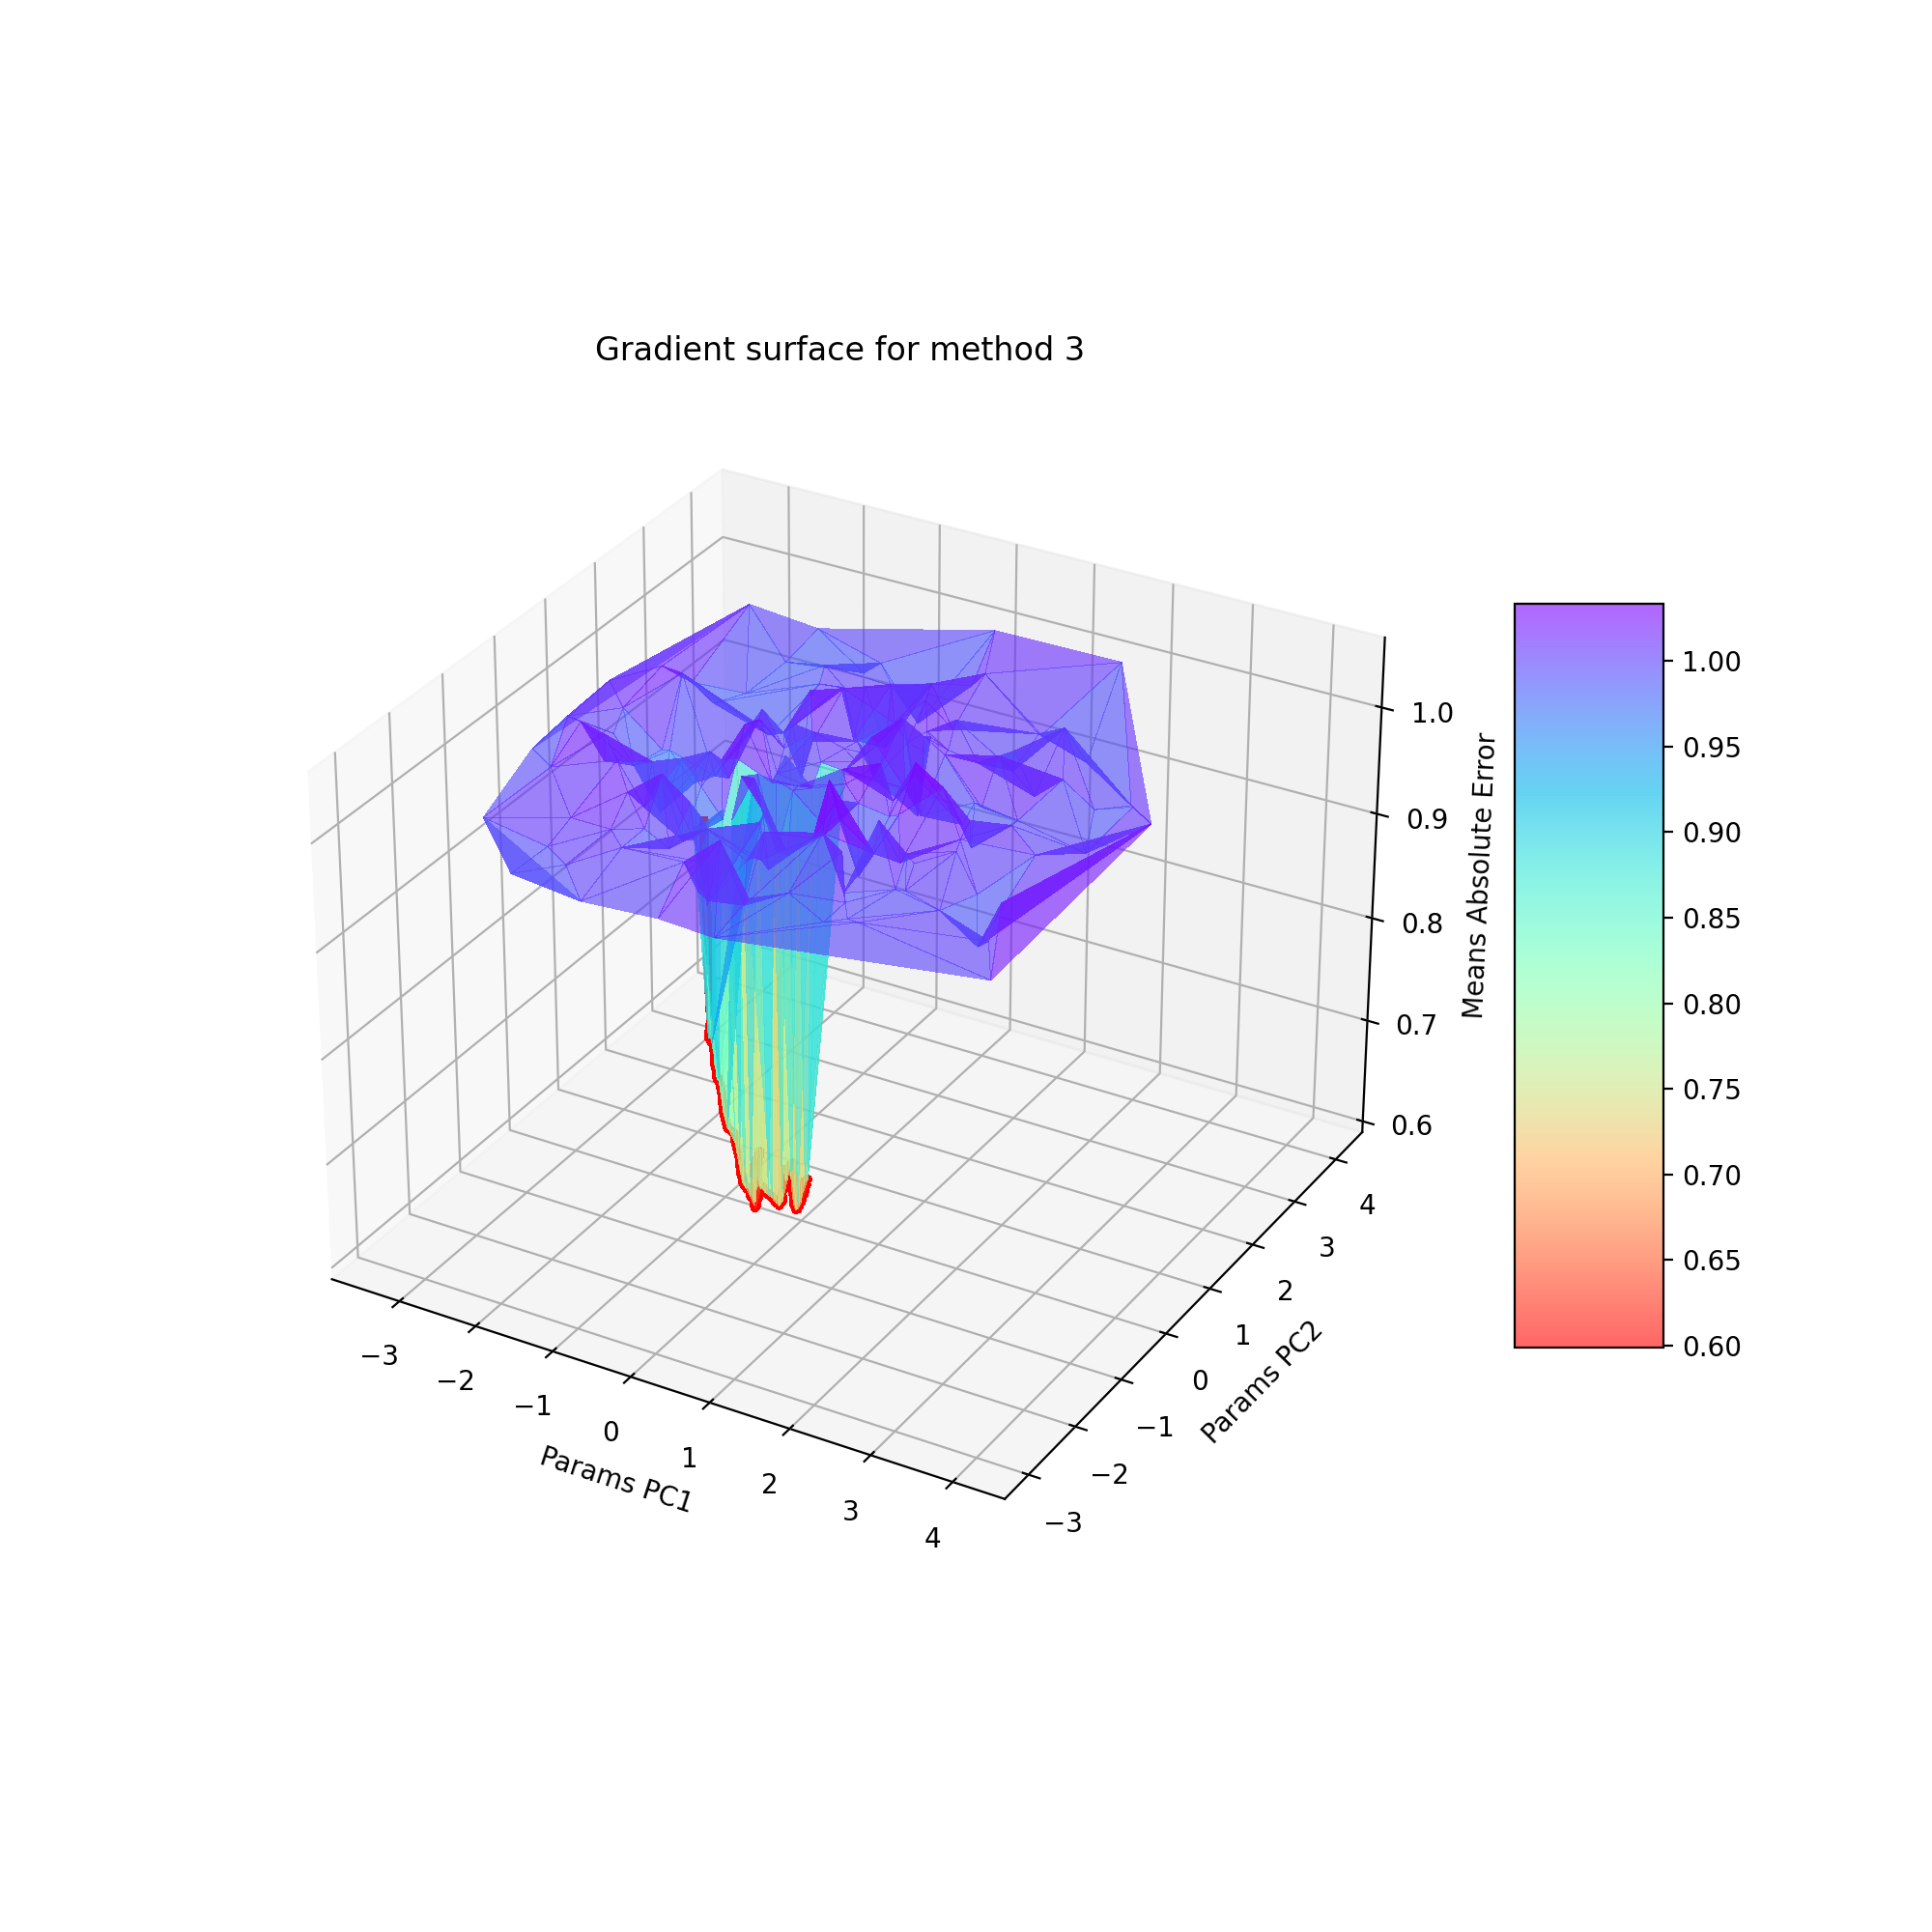

In [17]:
%matplotlib widget
plotSurface(surface3, path=path3, title='Gradient surface for method 3', dpi=200, save='m3.png')

In [ ]:
!pip list | grep qiskit

In [ ]:
!pip list | grep torch